In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
name = 'Alto_Maipo'
df_tweets = pd.read_excel('Results//' + name + '_tweets.xlsx') #Generadoras
df_subtema = pd.read_excel('Results//' + name + '_subtema.xlsx')
df_tema = pd.read_excel('Results//' + name + '_tema.xlsx')

In [6]:
def spider_chart(df, var1, var2, title):
    # ------- PART 1: Create background

    # number of variable
    categories=list(df)[1:]
    # Set data
    N = len(categories)
    sns.set_style("whitegrid")
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.rcParams["figure.figsize"] = (10,4)
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    # plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,1)

    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    var_list = df['index'].to_list()

    values = df.loc[var_list.index(var1)].drop('index').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Índice de comentarios positivos")
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values = df.loc[var_list.index(var2)].drop('index').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Índice de comentarios negativos", color='r')
    ax.fill(angles, values, 'r', alpha=0.1)

    #Add title
    plt.title(title)

    # Add legend
    plt.legend(loc='best', bbox_to_anchor=(0.2, 0., 0., 0.))


    # Show the graph
    plt.show()

In [7]:
df_tema

index       Salud  Seguridad pública  Sucesos naturales  Unnamed: 17
0        POS    4.000000           0.000000           2.000000     1.000000
1        NEG   66.000000          59.000000          75.000000   263.000000
2        NEU   92.000000          68.000000         116.000000   299.000000
3      Total  162.000000         127.000000         193.000000   563.000000
4  pos_index    0.024691           0.000000           0.010363     0.001776
5  neg_index    0.407407           0.464567           0.388601     0.467140

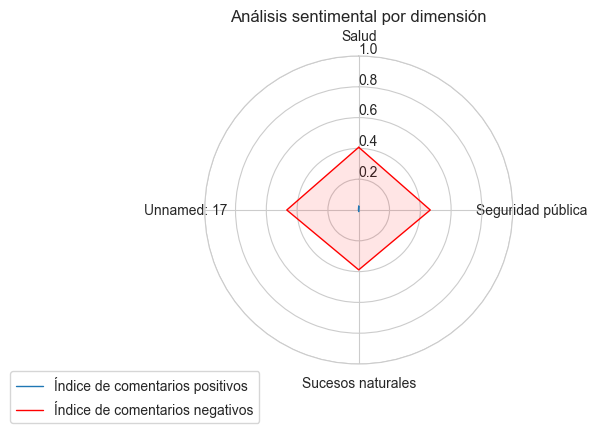

In [8]:
spider_chart(df_tema, 'pos_index', 'neg_index', 'Análisis sentimental por dimensión')

In [9]:
def subtopic(df1):
    temas = df1.tema.drop_duplicates().to_list()
    for i,tema in enumerate(temas):
        sentiment_options = ['POS', 'NEG', 'NEU']
        df = df1[df1['tema'] == tema]
        df['Total']= df[sentiment_options].sum(axis=1)
        df['pos_index'] = df.POS / df.Total
        df['neg_index'] = df.NEG / df.Total
        df = df.fillna(0)
        df = df[['subtema', 'pos_index', 'neg_index']].set_index('subtema')\
            .transpose().reset_index()
        title = str(tema)
        spider_chart(df, 'pos_index', 'neg_index', 'Análisis sentimental por dimensión: '+ title)

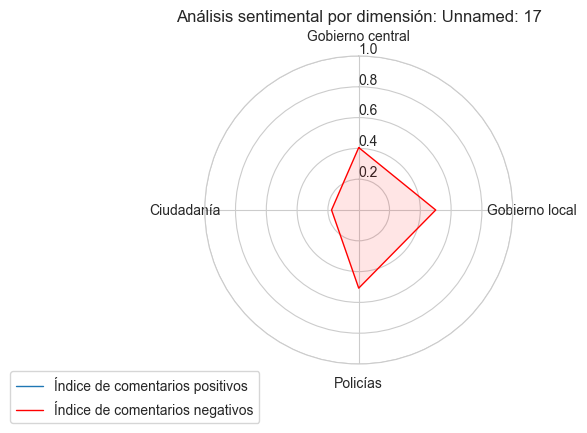

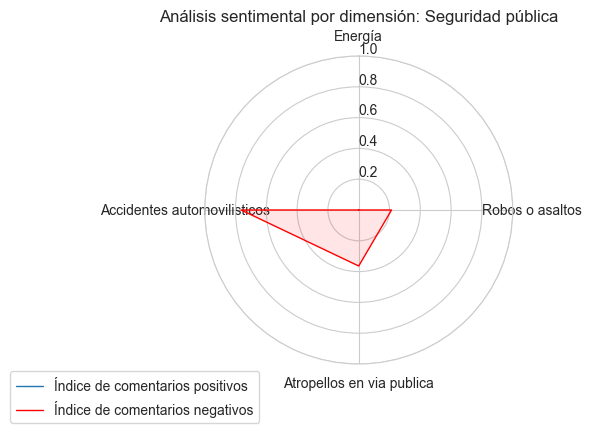

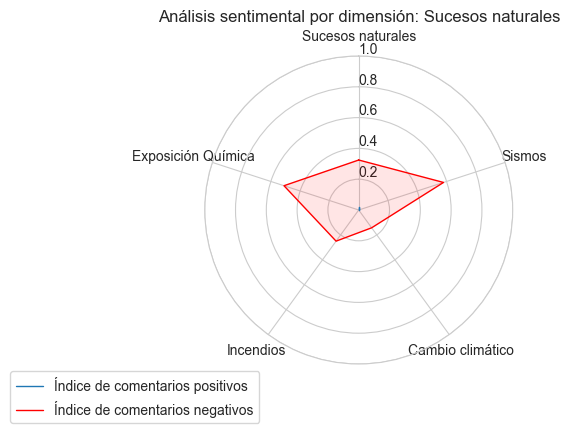

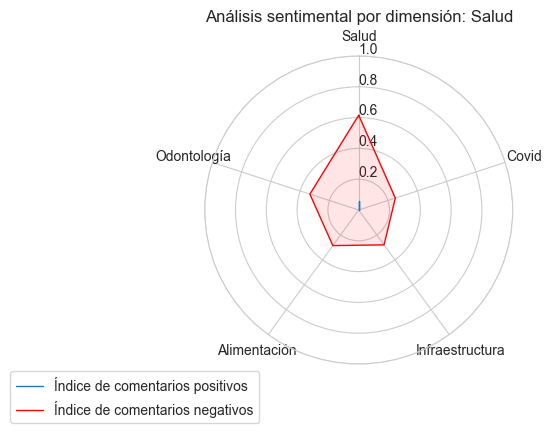

In [10]:
subtopic(df_subtema)

In [11]:
df_plot = df_tweets.groupby(['region', 'sentiment']).size().reset_index().pivot(columns='sentiment', index='region', values=0)
df_plot = df_plot.reset_index()
df_plot.columns = ['Región', 'Negativo', 'Neutro', 'Positivo']
df_plot = df_plot.fillna(0)
df_plot['Total'] = df_plot['Negativo'] + df_plot['Positivo'] + df_plot['Neutro']
df_plot['Negativo'] = df_plot['Negativo'] / df_plot['Total']
df_plot['Positivo'] = df_plot['Positivo'] / df_plot['Total']
df_plot['Neutro'] = df_plot['Neutro'] / df_plot['Total']
df_plot = df_plot[['Región', 'Negativo', 'Neutro', 'Positivo']]
df_plot = df_plot.set_index('Región')

/var/folders/nf/gc0__kh133b5ml5907fvy1xh0000gn/T/ipykernel_3260/40891369.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


<Figure size 1000x400 with 0 Axes>

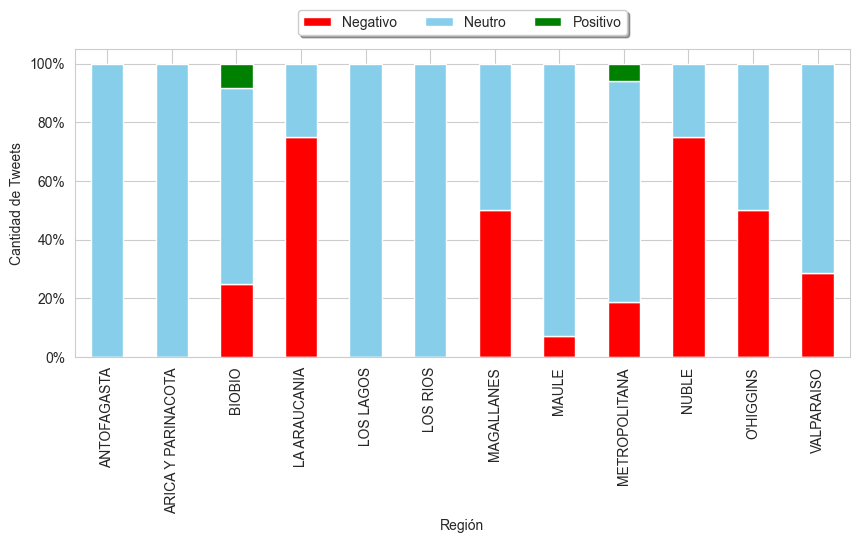

In [12]:
fig = plt.figure()
# ax = plt.subplot(111)
ax = df_plot.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)
ax.set_ylabel('Cantidad de Tweets')
ax.set_xlabel('Región')
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

In [13]:
df = pd.read_excel('Results/result_tweets.xlsx')

def preprocess_dataframe(df):
    #Connect dimension and subdimensions
    #get dimensions
    df_risk = pd.read_excel('Results/Risk_factors.xlsx')
    df_risk.columns = ['dim', 'dimension']
    df = pd.merge(df, df_risk, on='dim', how = 'left')

    #transforme column time into datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['hour'] = pd.to_datetime(df['hour'], format='%H')
    df['time'] = pd.to_datetime(df.date.astype(str) + ' ' + df.hour.astype(str)).dt.strftime("%Y-%m-%d %H:%M:%S")

    return df

def calculate_risk_factors(df, dimension):
    #get tweets by time, dimension and sentiment
    df_per_time = df.time.value_counts().reset_index()
    df_per_time.columns = ['time','total_tweets_per_time']
    df_per_dim = df.groupby([dimension, 'time'], as_index=False)['tweet'].count()
    df_per_dim.rename(columns={'tweet':'total_tweets_per_dimension'}, inplace=True)
    df_per_sent = df.groupby([dimension, 'sentiment','time'], as_index=False)['tweet'].count()
    df_per_sent.rename(columns={'tweet':'total_tweets_per_sentiment'}, inplace=True)

    #Combine into one dataframe
    df_sent_dim = pd.merge(df_per_sent, df_per_dim, how = 'left', left_on=[dimension, 'time'], right_on=[dimension, 'time'])
    df_final = pd.merge(df_sent_dim, df_per_time, how = 'left', left_on='time', right_on='time')

    #Calculate weight and risk index
    df_final['weight_by_dimension_time'] = df_final['total_tweets_per_dimension'] / df_final['total_tweets_per_time']
    df_final['sentiment_index_by_time'] = df_final['total_tweets_per_sentiment'] / df_final['total_tweets_per_dimension']
    df_final.drop(['total_tweets_per_sentiment','total_tweets_per_dimension', 'total_tweets_per_time'], axis = 1)

    #Get risk index
    df_final = df_final.pivot(index = [dimension, 'time', 'weight_by_dimension_time'], columns='sentiment', values='sentiment_index_by_time').reset_index()
    df_final.fillna(0, inplace=True)
    df_final['risk_index'] = (df_final['POS'] - df_final['NEG']) * df_final['weight_by_dimension_time']

    return df_final

def plot_risk_factors(df_final, dimension):
    #Plot elements
    ax = sns.lineplot(df_final, x='time', y='risk_index', hue=dimension)
    ax.set(ylim=(-1, 1))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
              ncol=5, fancybox=True, shadow=True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Índice de riesgo')
    ax.set_xlabel('Día y hora')

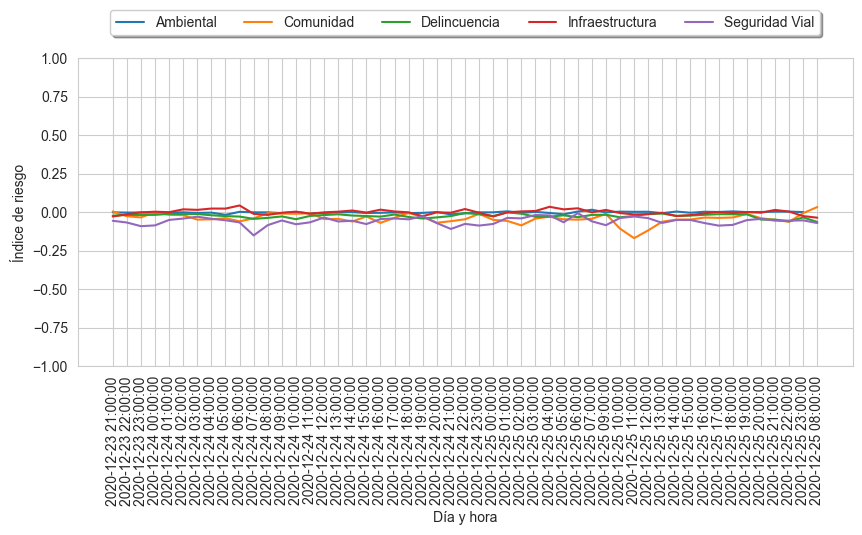

In [14]:
df = preprocess_dataframe(df)
df_final = calculate_risk_factors(df, 'dimension')
plot_risk_factors(df_final, 'dimension')

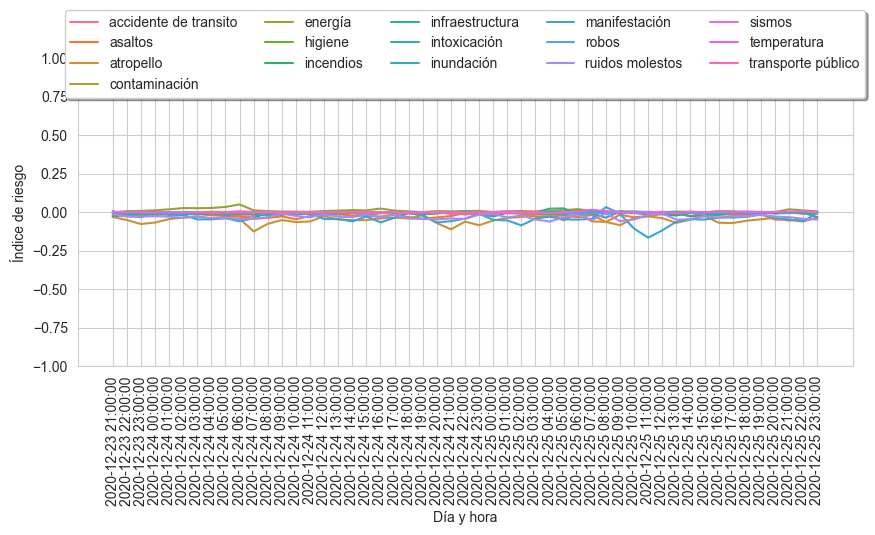

In [15]:
df = preprocess_dataframe(df)
df_final = calculate_risk_factors(df, 'dim')
plot_risk_factors(df_final, 'dim')

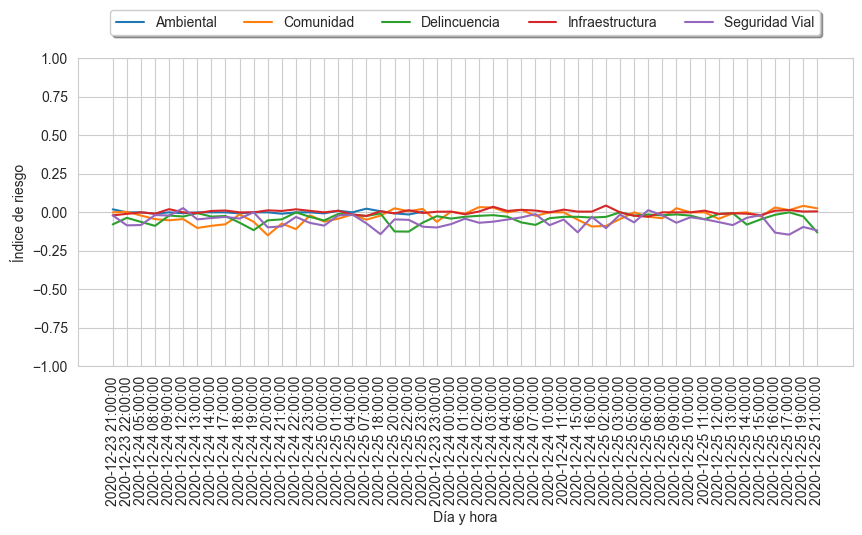

In [16]:
df = df[df['dim_prob']>40]
df = preprocess_dataframe(df)
df_final = calculate_risk_factors(df, 'dimension')
plot_risk_factors(df_final, 'dimension')

/var/folders/nf/gc0__kh133b5ml5907fvy1xh0000gn/T/ipykernel_3260/2159560433.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'dimension_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df_risk, on='dim', how = 'left')


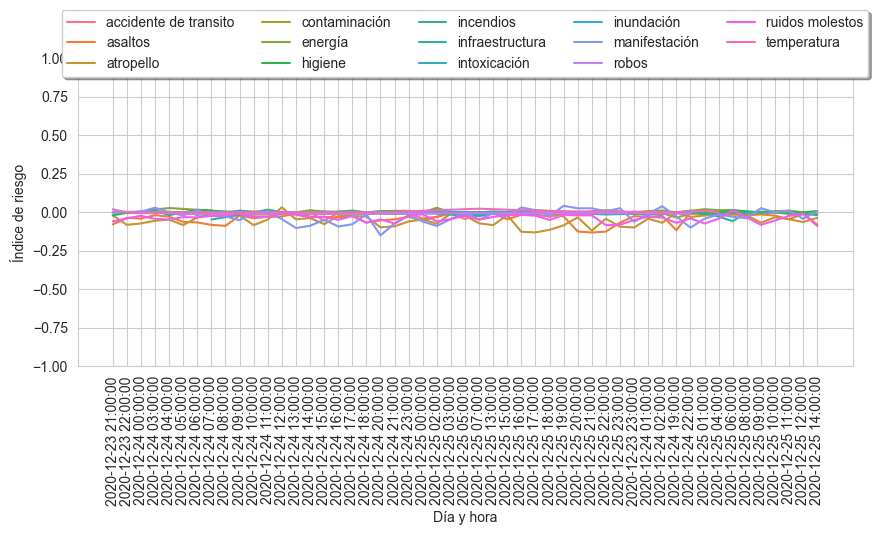

In [17]:
df = df[df['dim_prob']>40]
df = preprocess_dataframe(df)
df_final = calculate_risk_factors(df, 'dim')
plot_risk_factors(df_final, 'dim')

In [18]:
df_tema

index       Salud  Seguridad pública  Sucesos naturales  Unnamed: 17
0        POS    4.000000           0.000000           2.000000     1.000000
1        NEG   66.000000          59.000000          75.000000   263.000000
2        NEU   92.000000          68.000000         116.000000   299.000000
3      Total  162.000000         127.000000         193.000000   563.000000
4  pos_index    0.024691           0.000000           0.010363     0.001776
5  neg_index    0.407407           0.464567           0.388601     0.467140

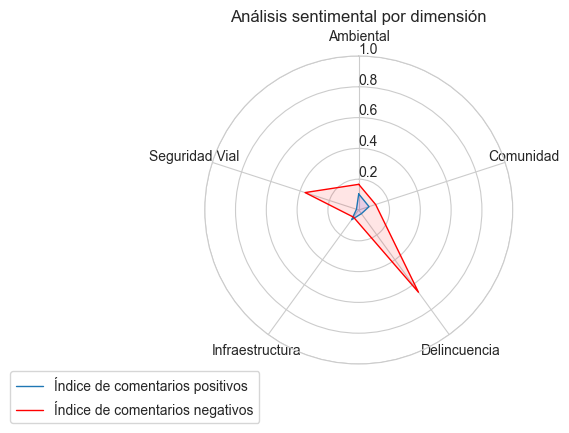

In [19]:
df1 = df[['dimension_y','sentiment']]
df1.columns = ['count', 'dimension_y','sentiment']
#df1 = df[['dimension_y','sentiment']]
df1 = pd.get_dummies(df1, columns=['sentiment'], prefix="", prefix_sep='')
df1 = df1.groupby(['dimension_y'], as_index=False).sum()
df1['Total'] = df1.POS + df1.NEG + df1.NEU
df1['pos_index'] = df1.POS / df1.Total
df1['neg_index'] = df1.NEG / df1.Total
df1 = df1.transpose().reset_index()
df1.columns = df1.iloc[0]
df1 = df1.iloc[pd.RangeIndex(len(df1)).drop(0)]
df1 = df1.rename(columns={'dimension_y':'index'})
df1 = df1.reset_index(drop=True)
df1
spider_chart(df1, 'pos_index', 'neg_index', 'Análisis sentimental por dimensión')

In [20]:
def calculate_factors(df, dimension):
    #get tweets by time, dimension and sentiment
    df_per_time = df.time.value_counts().reset_index()
    df_per_time.columns = ['time','total_tweets_per_time']
    df_per_dim = df.groupby([dimension, 'time'], as_index=False)['tweet'].count()
    df_per_dim.rename(columns={'tweet':'total_tweets_per_dimension'}, inplace=True)
    df_per_sent = df.groupby([dimension, 'sentiment','time'], as_index=False)['tweet'].count()
    df_per_sent.rename(columns={'tweet':'total_tweets_per_sentiment'}, inplace=True)

    #Combine into one dataframe
    df_sent_dim = pd.merge(df_per_sent, df_per_dim, how = 'left', left_on=[dimension, 'time'], right_on=[dimension, 'time'])
    df_final = pd.merge(df_sent_dim, df_per_time, how = 'left', left_on='time', right_on='time')

    #Calculate weight and risk index
    df_final['weight_by_dimension_time'] = df_final['total_tweets_per_dimension'] / df_final['total_tweets_per_time']
    df_final['sentiment_index_by_time'] = df_final['total_tweets_per_sentiment'] / df_final['total_tweets_per_dimension']
    df_final.drop(['total_tweets_per_sentiment','total_tweets_per_dimension', 'total_tweets_per_time'], axis = 1)

    #Get risk index
    df_final = df_final.pivot(index = [dimension, 'time', 'weight_by_dimension_time'], columns='sentiment', values='sentiment_index_by_time').reset_index()
    df_final.fillna(0, inplace=True)
    df_final['risk_index'] = (df_final['POS'] - df_final['NEG']) * df_final['weight_by_dimension_time']

    return df_final

In [76]:
df = pd.read_excel('Results/result_tweets.xlsx')
df = df[df['dim_prob']>40]
df = preprocess_dataframe(df)
df = df[['sentiment', 'dimension']]
dfw = df['dimension'].value_counts() / len(df)
df_sent = pd.get_dummies(df, columns=['sentiment'], prefix='', prefix_sep='')
df_sent = df_sent.groupby('dimension').sum()
df_sent['Total'] = df_sent.sum(axis=1)
df_sent['pos_index'] = df_sent['POS'] / df_sent['Total']
df_sent['neg_index'] = df_sent['NEG'] / df_sent['Total']
df_sent['sent_index'] = df_sent['pos_index'] - df_sent['neg_index']
df_sent = df_sent['sent_index']

In [77]:
try:
    dfw = dfw.to_frame()
except:
    dfw = dfw
dfw.columns = ['peso']
df = pd.concat([df_sent,dfw], axis = 1)

In [78]:
df['risk_index'] = df.sent_index * df.peso
df = df['risk_index']

In [81]:
risk_index = df.sum()
print('El índice de riesgo es: ', risk_index)

El índice de riesgo es:  -0.12313379781032278


In [83]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

trace1 = go.Indicator(mode="gauge+number",    value=400,    domain={'row' : 1, 'column' : 1}, title={'text': "Speed 1"})
trace2 = go.Indicator(mode="gauge+number",    value=250,    domain={'row' : 1, 'column' : 2}, title={'text': "Speed 2"})

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}]],
    )

fig.append_trace(trace1, row=1, col=1)
fig.append_trace(trace2, row=1, col=2)

fig.show()

In [117]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = risk_index,
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "Índice de Riesgo Global", 'font': {'size': 24}},
    #delta = {'reference': 0.5, 'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [-1, 1], 'tickwidth': 0, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        #'bgcolor': "white",
        'borderwidth': 1,
        'bordercolor': "black",
        'steps': [
            {'range':[-1, -0.8], 'color': 'rgb(246,105,107)'},
            {'range':[-0.8, -0.6], 'color': 'rgb(247,130,111)'},
            {'range':[-0.6, -0.4], 'color': 'rgb(248,157,117)'},
            {'range':[-0.4, -0.2], 'color': 'rgb(250,183,123)'},
            {'range':[-0.2, 0], 'color': 'rgb(252,209,127)'},
            {'range':[0, 0.2], 'color': 'rgb(254,235,132)'},
            {'range':[0.2, 0.4], 'color': 'rgb(224,227,131)'},
            {'range':[0.4, 0.6], 'color': 'rgb(193,218,129)'},
            {'range':[0.6, 0.8], 'color': 'rgb(162,208,127)'},
            {'range':[0.8, 1], 'color': 'rgb(131,198,125)'}
        ],

        'threshold': {
            'line': {'color': "red", 'width': 1},
            'thickness': 0.75,
            'value': 0}}))

fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

fig.show()